<a href="https://colab.research.google.com/github/gtbook/gtsam-examples/blob/main/PlanarSLAMExample_gvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Bayes Inference

GTSAM is most-often used for posteriori (MAP) estimation, and with the `gtsam.Marginals` object we can get the Laplace approximation to the posterior density. As shown in a [2020 IJRR paper by Tim Barfoot et al](https://journals.sagepub.com/doi/abs/10.1177/0278364920937608), variational Bayes not only optimizes for the mean $\mu$ but also for the covariance $\Sigma$ of an approximation 

$$
q(x) \sim \mathcal{N}(x;\mu, \Sigma).
$$

The key is that we need to take expectations of the factor log-likelihoods with respect to $q(x)$, and a simple way to do this is to *sample* from $q$. The recipe we follow below is then:

- initialize $q(x)$ with MAP and Laplace approximation.
- for a few times:
  - sample from q
  - create linearized factors using the q samples
  - optimize this graph

Note that we sample from $q$, not the true posterior, which would be much harder. In the version below, which uses ancestral sampling to create the expectations, we do not need the marginals of Q explicitly, even though we do compute them in various places to draw covariance ellipses for visualization purposes.

In [62]:
%pip -q install gtbook # also installs latest gtsam pre-release

Note: you may need to restart the kernel to use updated packages.


In [63]:
import math
from math import pi, sqrt
import matplotlib.pyplot as plt
import numpy as np

import gtsam
import gtsam.utils.plot as gtsam_plot
from gtbook.display import show
from gtsam import Point2, Pose2, Rot2, noiseModel

## Setting up a non-linear SLAM Example

Below we re-create a similar factor graph as in `PlanarSLAMExample`, but with highly nonlinear measurements on the landmarks. Take a look at the sampling example to appreciate how non-Gaussian the posteriors are in this example.

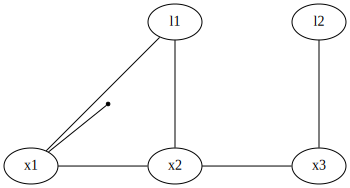

In [64]:
x1 = gtsam.symbol('x', 1)
x2 = gtsam.symbol('x', 2)
x3 = gtsam.symbol('x', 3)

graph = gtsam.NonlinearFactorGraph()
priorMean = Pose2(0.0, 0.0, 0.0)  # prior at origin
priorNoise = noiseModel.Diagonal.Sigmas([0.01, 0.01, math.radians(1)])
graph.add(gtsam.PriorFactorPose2(x1, priorMean, priorNoise))  # add directly to graph
odometry = Pose2(2.0, 0.0, 0.0)
odometryNoise = noiseModel.Diagonal.Sigmas([0.05, 0.02, math.radians(2)])
graph.add(gtsam.BetweenFactorPose2(x1, x2, odometry, odometryNoise))
graph.add(gtsam.BetweenFactorPose2(x2, x3, odometry, odometryNoise))

# Except, we use bearing only measurements for l1
l1 = gtsam.symbol('l', 1)
l2 = gtsam.symbol('l', 2)
bearingModel = noiseModel.Diagonal.Sigmas([0.1])
graph.add(gtsam.BearingFactor2D(x1, l1, Rot2(math.radians(45)), bearingModel))
graph.add(gtsam.BearingFactor2D(x2, l1, Rot2(math.radians(90)), bearingModel))

brNoise = noiseModel.Diagonal.Sigmas([math.radians(25), 0.1])
graph.add(gtsam.BearingRangeFactor2D(x3, l2, Rot2(math.radians(90)), 2, brNoise))

# Values with ground truth
truth = gtsam.Values()
truth.insert(x1, Pose2(0, 0, 0))
truth.insert(x2, Pose2(2, 0, 0))
truth.insert(x3, Pose2(4, 0, 0))
truth.insert(l1, Point2(2, 2))
truth.insert(l2, Point2(4, 2))

show(graph, truth, binary_edges=True)


As always, we can calculate and plot covariance ellipses which show the Laplace approximation graphically.

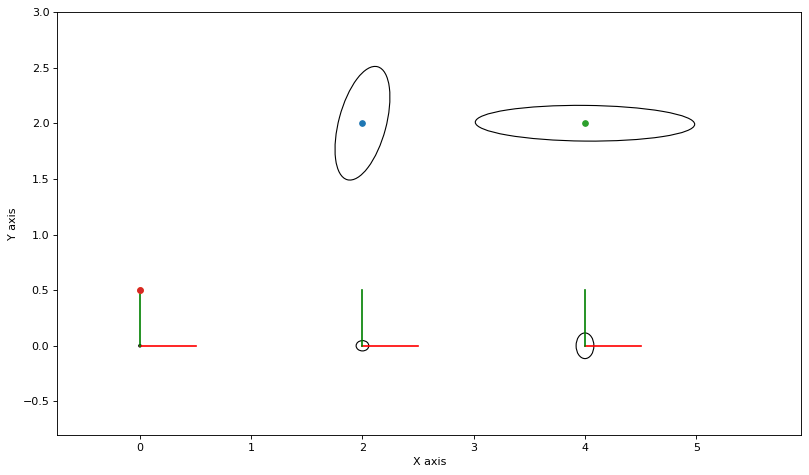

In [65]:
marginals = gtsam.Marginals(graph, truth)
def make_figure():
    plt.figure(0, figsize=(12, 7), dpi=80)
    for key in [x1, x2, x3]:
        gtsam_plot.plot_pose2(0, truth.atPose2(key), 0.5,
                            marginals.marginalCovariance(key))
    for key in [l1, l2]:
        gtsam_plot.plot_point2(0, truth.atPoint2(key), 0.5,
                            marginals.marginalCovariance(key))

    plt.axis('equal')
    plt.xlim([-0.8, 6])
    plt.ylim([-0.8, 3])

make_figure()

## Ancestral Sampling

To form the expectations for variational Bayes, we set up an efficient ancestral sampler for a Bayes net below.  This is not yet implemented inside GTSAM for the fully general case, but will be soon.   It returns a dictionary of samples in the *tangent space* of each variable manifold, at the ground truth values.

In [66]:
def sample_gaussian(bn: gtsam.GaussianBayesNet, N):
    """ High performance ancestral sampling.
        TODO: move to GTSAM, yet yield dict of samples as below
    """
    sample = {}
    for i in reversed(range(bn.size())):
        # every node ~ exp(0.5*|R x + S p - d|^2)
        # calculate mean as inv(R)*(d - S p)
        node = bn.at(i)
        d = node.d()
        n = len(d)
        rhs = d.reshape(n, 1)
        key, *parents = node.keys()
        if len(parents) > 0:
            rhs = rhs - node.S() @ np.vstack([sample[p] for p in parents])
        # sample from conditional Gaussian
        invR = np.linalg.inv(node.R())
        sample[key] = invR @ (rhs + np.random.normal(size=(n, N)))
    return sample


The above creates samples in the *tangent space*, which we then need to upgrade to the non-linear manifold:

In [67]:
def perturb(tangent_samples:dict, values:gtsam.Values, s:int):
    vv = gtsam.VectorValues()
    for key in tangent_samples.keys():
        vv.insert(key, tangent_samples[key][:, s])
    return values.retract(vv)  # all variables updated

## Variational Bayes

The code below then uses this sampler to create samples on the product manifold, each sample yielding linearized factors at the sample, yielding a new Gaussian factor graph which has $N$ times as many factors. We then optimize that graph and iterate:

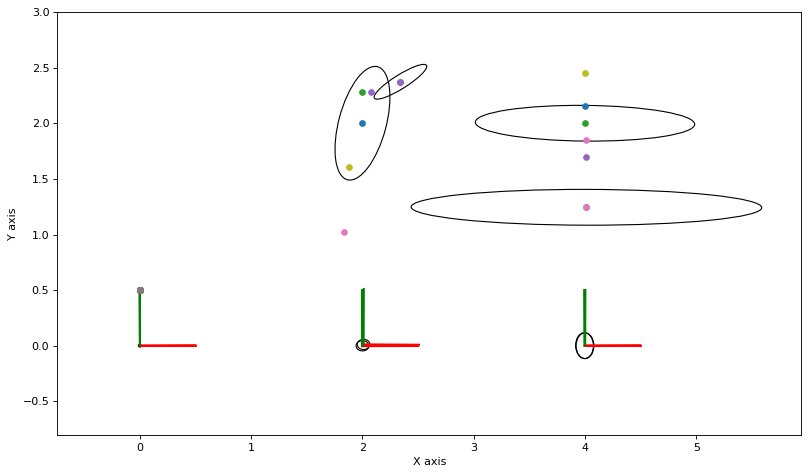

In [89]:
N = 1000

# Start with ground truth
values = gtsam.Values()
values.insert(x1, Pose2(0, 0, 0))
values.insert(x2, Pose2(2, 0, 0))
values.insert(x3, Pose2(4, 0, 0))
values.insert(l1, Point2(2, 2))
values.insert(l2, Point2(4, 2))

big_graph = graph.linearize(values)  # first time it's small!
bayes_net = big_graph.eliminateSequential()

make_figure()

for it in range(5):
    # Use the Bayes net to sample from q:
    tangent_samples = sample_gaussian(bayes_net, N)
    manifold_samples = [perturb(tangent_samples, values, s) for s in range(N)]

    # Add new linearized factors for every sample:
    big_graph = gtsam.GaussianFactorGraph()
    for manifold_sample in manifold_samples:
        sample_graph = graph.linearize(manifold_sample)
        big_graph.push_back(sample_graph)

    # Solve by calculating Bayes net and solving:
    bayes_net = big_graph.eliminateSequential()
    delta = bayes_net.optimize()

    # update non-linear estimate
    values = values.retract(delta)
    for key in [x1, x2, x3]:
        gtsam_plot.plot_pose2(0, values.atPose2(key), 0.5)
    for key in [l1, l2]:
        gtsam_plot.plot_point2(0, values.atPoint2(key), 0.5)

# show new covariances
new_marginals = gtsam.Marginals(big_graph, values)
for key in [x1, x2, x3]:
    gtsam_plot.plot_pose2(0, values.atPose2(key), 0.5,
                          N*new_marginals.marginalCovariance(key))
for key in [l1, l2]:
    gtsam_plot.plot_point2(0, values.atPoint2(key), 0.5,
                           N*new_marginals.marginalCovariance(key))

Comparing this with the MCMC result, it seems to evolve in the right direction, although the approximation on $l_1$ seems off and overconfident.